# DeepRoute SDN on Chameleon using Reinforcement Learning

In this experiment, we develop a reinforcement learning approach, in particular Upper-Confidence Algorithm(UCB) and Thompson Sampling which we then compared with Random Selection Algorithm, to learn optimal paths    and re-route traffic to improve network utilization. We present throughput and flow diversions using Mininet and demo the technique using Chameleon’s Testbed . This project is an initial implementation towards DeepRoute, which combines Deep reinforcement learning algorithms with SDN controllers to create and route traffic using deployed OpenFlow switches.
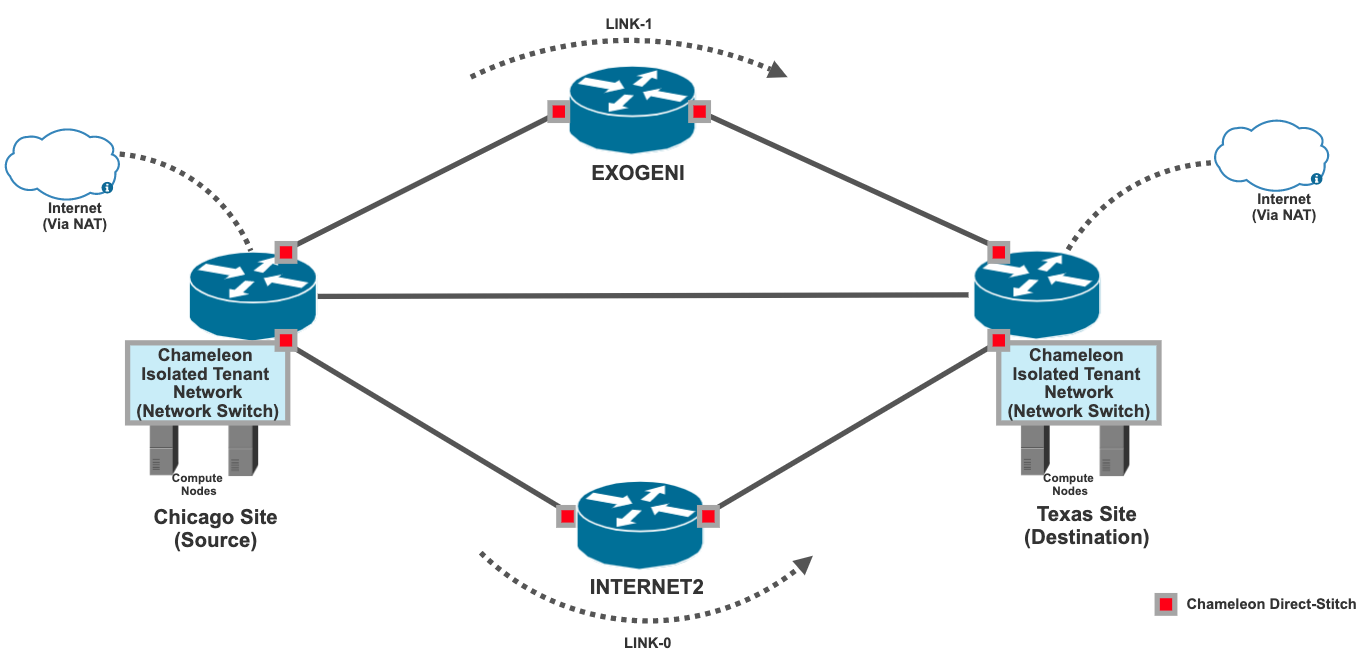

###  Set Deep-Route's Enviroment 

In [1]:
# Set up user's project (user's can be multiple ones, so there is no default currently)
export OS_PROJECT_NAME='MC4N'

# Set chameleon keypair name and path to the private ssh key
export SSH_KEY_NAME=${USERNAME}-uc-key
export SSH_PRIVATE_KEY=${HOME}/work/bashir-chameleon-jupyter

export NETWORK_SUBNET="192.168.100.0/24"
export UC_ALLOCATION_START="192.168.100.10"
export UC_ALLOCATION_END="192.168.100.19"
export TACC_ALLOCATION_START="192.168.100.20"
export TACC_ALLOCATION_END="192.168.100.29"

export RESOURCE_PREFIX="$USER-deeproute-$(date +%b%d)"

export GENI_PEM_FILE="~/work/geni-bmohamme.pem"

### Set Deep-Route Variables 
  - `OS_PROJECT_NAME`: The name of the project you want to use.
  - `UC_RESERVATION`: Reservation ID at UC.
  - `TACC_RESERVATION`: Reservation ID at TACC.
  - `SSH_KEY_NAME`: SSH key name as registered in Chameleon
  - `SSH_PRIVATE_KEY`: Path to the corresponding private key in your Jupyter container.
  - `NETWORK_SUBNET`: Private IP subnet that will span both Chameleon sites.
  - `UC_ALLOCATION_START`: The start of the IP range assigned at the UC site.
  - `UC_ALLOCATION_END`: The end of the IP range assigned at the UC site.
  - `TACC_ALLOCATION_START`: The start of the IP range assigned at the TACC site.
  - `TACC_ALLOCATION_END`: The start of the IP range assigned at the TACC site.
  - `RESOURCE_PREFIX`: A begin string used to idenify resources provision. This includes your user ID so that your resources can be distinguised from those belonging to other tutorial particpants.
  - `GENI_PEM_FILE`: The path to your GENI certificate file in you Jupyter container.
  - `UC_DIRECTSTITCH_VLAN`: The VLAN using to attach to the DirectStitch port at UC.
  - `TACC_DIRECTSTITCH_VLAN`: The VLAN using to attach to the DirectStitch port at TACC.

In [2]:
pwd

/work/work


In [3]:
UC_RESERVATION_NAME=${RESOURCE_PREFIX}"-UC"

# Set the names for the network, subnet, router, and switch. 
UC_NETWORK_NAME=${RESOURCE_PREFIX}"-Network-UC"
UC_SUBNET_NAME=${RESOURCE_PREFIX}"-Subnet-UC"
UC_ROUTER_NAME=${RESOURCE_PREFIX}"-Router-UC"

### Creating a Deep-Route Network on the UC Chameleon Site

In [4]:
OS_REGION_NAME='CHI@UC'

START_DATE=`date -d "+2 min" +'%F %H:%M'`
END_DATE=`date -d "+5 day" +'%F %H:%M'`

PUBLIC_NETWORK_ID=$(openstack network show public -c id -f value)

echo Creating network ${EXOGENI_STITCH_NAME}
blazar lease-create \
   --physical-reservation min=1,max=2,resource_properties='["=", "$node_type", "compute_haswell"]' \
   --reservation resource_type=virtual:floatingip,network_id=${PUBLIC_NETWORK_ID},amount=1 \
   --reservation resource_type="network",network_name="${UC_NETWORK_NAME}",resource_properties='["==","$physical_network","exogeni"]' \
   --start-date "${START_DATE}" \
   --end-date "${END_DATE}" \
   ${UC_RESERVATION_NAME}

UC_RESERVATION=`blazar lease-show --format value -c id ${UC_RESERVATION_NAME}`
echo UC_RESERVATION $UC_RESERVATION

UC_NODE_RESERVATION=`blazar lease-show -json --format value -c reservations ${UC_RESERVATION_NAME} | jq -r 'select(.resource_type | contains("physical:host")) | .id'`
echo UC_NODE_RESERVATION $UC_NODE_RESERVATION

Creating network
Matches: ('min=1,max=2', 'resource_properties', '["=", "$node_type", "compute_haswell"]')
Matches: ('min=1', 'max', '2')
Matches: (None, 'min', '1')
Matches: ('resource_type=virtual:floatingip,network_id=44b38c44-2a42-4b6d-b129-6c8f1b2a1375', 'amount', '1')
Matches: ('resource_type=virtual:floatingip', 'network_id', '44b38c44-2a42-4b6d-b129-6c8f1b2a1375')
Matches: (None, 'resource_type', 'virtual:floatingip')
Matches: ('resource_type=network,network_name=bmohd1-deeproute-Oct13-Network-UC', 'resource_properties', '["==","$physical_network","exogeni"]')
Matches: ('resource_type=network', 'network_name', 'bmohd1-deeproute-Oct13-Network-UC')
Matches: (None, 'resource_type', 'network')
Created a new lease:
+--------------+----------------------------------------------------------------------------+
| Field        | Value                                                                      |
+--------------+--------------------------------------------------------------------

In [6]:
OS_REGION_NAME='CHI@UC'

UC_DIRECTSTITCH_VLAN=`openstack network show -c provider:segmentation_id -f value ${UC_NETWORK_NAME}`
echo UC DirectStitch VLAN: $UC_DIRECTSTITCH_VLAN 

UC_FLOATING_IP=`lease_list_floating_ips $UC_RESERVATION`
echo UC_FLOATING_IP $UC_FLOATING_IP 

UC DirectStitch VLAN: 3291
UC_FLOATING_IP 192.5.87.223


In [7]:
OS_REGION_NAME='CHI@UC'
echo Creating Subnet
openstack subnet create --max-width 80 \
                        --subnet-range ${NETWORK_SUBNET} \
                        --allocation-pool start=${UC_ALLOCATION_START},end=${UC_ALLOCATION_END} \
                        --dhcp \
                        --network ${UC_NETWORK_NAME} \
                        ${UC_SUBNET_NAME}
                        
echo Creating Router
openstack router create --max-width 80 ${UC_ROUTER_NAME}

echo Linking router to subnet
openstack router add subnet ${UC_ROUTER_NAME} ${UC_SUBNET_NAME}

echo Linking router to external gateway
openstack router set --external-gateway public ${UC_ROUTER_NAME}

echo Network ${UC_NETWORK_NAME} is ready for nodes!

Creating Subnet
+-------------------+----------------------------------------------------------+
| Field             | Value                                                    |
+-------------------+----------------------------------------------------------+
| allocation_pools  | 192.168.100.10-192.168.100.19                            |
| cidr              | 192.168.100.0/24                                         |
| created_at        | 2019-10-13T12:58:27Z                                     |
| description       |                                                          |
| dns_nameservers   |                                                          |
| enable_dhcp       | True                                                     |
| gateway_ip        | 192.168.100.1                                            |
| host_routes       |                                                          |
| id                | 70ee97c8-ea2e-4703-b15d-e240af38489c                     |
| ip_version

In [9]:
UC_NODE_NAME=${RESOURCE_PREFIX}-node

OS_REGION_NAME='CHI@UC'
echo Creating servers... This will take several minutes! 
openstack server create --max-width 80 \
                        --flavor "baremetal" \
                        --image "CC-Ubuntu16.04" \
                        --key-name "uc-key" \
                        --hint reservation=${UC_NODE_RESERVATION} \
                        --security-group default  \
                        --nic net-id=${UC_NETWORK_NAME} \
                        ${UC_NODE_NAME}

Creating servers... This will take several minutes!
+-------------------------------------+----------------------------------------+
| Field                               | Value                                  |
+-------------------------------------+----------------------------------------+
| OS-DCF:diskConfig                   | MANUAL                                 |
| OS-EXT-AZ:availability_zone         |                                        |
| OS-EXT-SRV-ATTR:host                | None                                   |
| OS-EXT-SRV-ATTR:hypervisor_hostname | None                                   |
| OS-EXT-SRV-ATTR:instance_name       |                                        |
| OS-EXT-STS:power_state              | NOSTATE                                |
| OS-EXT-STS:task_state               | scheduling                             |
| OS-EXT-STS:vm_state                 | building                               |
| OS-SRV-USG:launched_at              | None             

In [10]:
OS_REGION_NAME='CHI@UC'
#Attach the floating IP address to the server
echo $UC_FLOATING_IP 
openstack server add floating ip $UC_NODE_NAME $UC_FLOATING_IP 

192.5.87.223


### Creating a Deep-Route Network on the TACC Chameleon Site
 We simply repeat the above steps but targetting TACC site

In [11]:
# Set up user's project (user's can be multiple ones, so there is no default currently)
export OS_PROJECT_NAME='MC4N'

# Set chameleon keypair name and path to the private ssh key
export SSH_KEY_NAME=${USERNAME}-uc-key
export SSH_PRIVATE_KEY=${HOME}/work/bashir-chameleon-jupyter

export NETWORK_SUBNET="192.168.100.0/24"
export UC_ALLOCATION_START="192.168.100.10"
export UC_ALLOCATION_END="192.168.100.19"
export TACC_ALLOCATION_START="192.168.100.20"
export TACC_ALLOCATION_END="192.168.100.29"

export RESOURCE_PREFIX="$USER-deeproute-$(date +%b%d)"

export GENI_PEM_FILE="~/work/geni-bmohamme.pem"

In [12]:
OS_REGION_NAME='CHI@TACC'

TACC_RESERVATION_NAME=${RESOURCE_PREFIX}"-TACC"

# Set the names for the network, subnet, router, and switch. 
# See above about using identifiable names.  
TACC_NETWORK_NAME=${RESOURCE_PREFIX}"-Network-TACC"
TACC_SUBNET_NAME=${RESOURCE_PREFIX}"-Subnet-TACC"
TACC_ROUTER_NAME=${RESOURCE_PREFIX}"-Router-TACC"

In [13]:
pwd

/work/work


In [14]:
OS_REGION_NAME='CHI@TACC'

START_DATE=`date -d "+2 min" +'%F %H:%M'`
END_DATE=`date -d "+5 day" +'%F %H:%M'`

PUBLIC_NETWORK_ID=$(openstack network show public -c id -f value)

echo Creating network ${EXOGENI_STITCH_NAME}
blazar lease-create \
   --physical-reservation min=1,max=5,resource_properties='["=", "$node_type", "compute_haswell"]' \
   --reservation resource_type=virtual:floatingip,network_id=${PUBLIC_NETWORK_ID},amount=1 \
   --reservation resource_type="network",network_name="${TACC_NETWORK_NAME}",resource_properties='["==","$physical_network","exogeni"]' \
   --start-date "${START_DATE}" \
   --end-date "${END_DATE}" \
   ${TACC_RESERVATION_NAME}

TACC_RESERVATION=`blazar lease-show --format value -c id ${TACC_RESERVATION_NAME}`
echo TACC_RESERVATION $TACC_RESERVATION

TACC_NODE_RESERVATION=`blazar lease-show -json --format value -c reservations ${TACC_RESERVATION} | jq -r 'select(.resource_type | contains("physical:host")) | .id'`
echo TACC_NODE_RESERVATION $TACC_NODE_RESERVATION
   
   
   

Creating network
Matches: ('min=1,max=5', 'resource_properties', '["=", "$node_type", "compute_haswell"]')
Matches: ('min=1', 'max', '5')
Matches: (None, 'min', '1')
Matches: ('resource_type=virtual:floatingip,network_id=6189521e-06a0-4c43-b163-16cc11ce675b', 'amount', '1')
Matches: ('resource_type=virtual:floatingip', 'network_id', '6189521e-06a0-4c43-b163-16cc11ce675b')
Matches: (None, 'resource_type', 'virtual:floatingip')
Matches: ('resource_type=network,network_name=bmohd1-deeproute-Oct13-Network-TACC', 'resource_properties', '["==","$physical_network","exogeni"]')
Matches: ('resource_type=network', 'network_name', 'bmohd1-deeproute-Oct13-Network-TACC')
Matches: (None, 'resource_type', 'network')
Created a new lease:
+--------------+----------------------------------------------------------------------------+
| Field        | Value                                                                      |
+--------------+----------------------------------------------------------------

In [15]:
OS_REGION_NAME='CHI@TACC'
TACC_DIRECTSTITCH_VLAN=`openstack network show -c provider:segmentation_id -f value ${TACC_NETWORK_NAME}`
echo TACC DirectStitch VLAN: $TACC_DIRECTSTITCH_VLAN 

TACC_FLOATING_IP=`lease_list_floating_ips $TACC_RESERVATION`
echo TACC_FLOATING_IP $TACC_FLOATING_IP 


TACC DirectStitch VLAN: 3507
TACC_FLOATING_IP 129.114.109.223


In [16]:
OS_REGION_NAME='CHI@TACC'
echo Creating Subnet
openstack subnet create --max-width 80 \
                        --subnet-range ${NETWORK_SUBNET} \
                        --allocation-pool start=${TACC_ALLOCATION_START},end=${TACC_ALLOCATION_END} \
                        --dhcp \
                        --network ${TACC_NETWORK_NAME} \
                        ${TACC_SUBNET_NAME}
                        
echo Creating Router
openstack router create --max-width 80 ${TACC_ROUTER_NAME}

echo Linking router to subnet
openstack router add subnet ${TACC_ROUTER_NAME} ${TACC_SUBNET_NAME}

echo Linking router to external gateway
openstack router set --external-gateway public ${TACC_ROUTER_NAME}

echo Network ${TACC_NETWORK_NAME} is ready for nodes!

Creating Subnet
+-------------------+----------------------------------------------------------+
| Field             | Value                                                    |
+-------------------+----------------------------------------------------------+
| allocation_pools  | 192.168.100.20-192.168.100.29                            |
| cidr              | 192.168.100.0/24                                         |
| created_at        | 2019-10-13T14:17:46Z                                     |
| description       |                                                          |
| dns_nameservers   |                                                          |
| enable_dhcp       | True                                                     |
| gateway_ip        | 192.168.100.1                                            |
| host_routes       |                                                          |
| id                | 86938810-ce6f-43c5-aef9-00e5462fd9a0                     |
| ip_version

In [17]:
echo TACC_RESERVATION $TACC_RESERVATION

TACC_NODE_NAME=${RESOURCE_PREFIX}-node

OS_REGION_NAME='CHI@TACC'
echo Creating servers... This will take several minutes! 
openstack server create --max-width 80 \
                        --flavor "baremetal" \
                        --image "CC-Ubuntu16.04"\
                        --key-name "tac-key" \
                        --hint reservation=${TACC_NODE_RESERVATION} \
                        --security-group default  \
                        --nic net-id=${TACC_NETWORK_NAME} \
                        ${TACC_NODE_NAME}


TACC_RESERVATION 0648e286-b788-471d-99f1-008769839a8f
Creating servers... This will take several minutes!
+-------------------------------------+----------------------------------------+
| Field                               | Value                                  |
+-------------------------------------+----------------------------------------+
| OS-DCF:diskConfig                   | MANUAL                                 |
| OS-EXT-AZ:availability_zone         |                                        |
| OS-EXT-SRV-ATTR:host                | None                                   |
| OS-EXT-SRV-ATTR:hypervisor_hostname | None                                   |
| OS-EXT-SRV-ATTR:instance_name       |                                        |
| OS-EXT-STS:power_state              | NOSTATE                                |
| OS-EXT-STS:task_state               | scheduling                             |
| OS-EXT-STS:vm_state                 | building                               |
| O

In [18]:
OS_REGION_NAME='CHI@TACC'

#Attach the floating IP address to the server
echo $TACC_FLOATING_IP 
openstack server add floating ip $TACC_NODE_NAME $TACC_FLOATING_IP 

129.114.109.223


### Use ExoGENI to Connect Ports on Deep-Route's Network using DirectStiching

In [20]:
echo UC DirectStitch VLAN:   $UC_DIRECTSTITCH_VLAN
echo TACC DirectStitch VLAN: $TACC_DIRECTSTITCH_VLAN
xoStitch create -sp1 uc -vlan1 $UC_DIRECTSTITCH_VLAN -sp2 tacc -vlan2 $TACC_DIRECTSTITCH_VLAN -c $GENI_PEM_FILE

UC DirectStitch VLAN: 3291
TACC DirectStitch VLAN: 3507
Opening certificate ~/work/geni-bmohamme.pem and key ~/work/geni-bmohamme.pem
log4j:WARN No appenders could be found for logger (org.renci.ahab.libndl.LIBNDL).
log4j:WARN Please initialize the log4j system properly.


In [2]:
#Get the status of the ExoGENI circuit
export GENI_PEM_FILE=geni-bmohamme.pem
TACC_DIRECTSTITCH_VLAN=3508
UC_DIRECTSTITCH_VLAN=3292
xoStitch status -sp1 uc -vlan1 $UC_DIRECTSTITCH_VLAN -sp2 tacc -vlan2 $TACC_DIRECTSTITCH_VLAN -c $GENI_PEM_FILE


Opening certificate geni-bmohamme.pem and key geni-bmohamme.pem
Exception in thread "main" org.renci.ahab.libtransport.util.UtilTransportException: SSHAccessTokenFileFactory unable to load user public ssh key /home/bmohd1/.ssh/id_rsa.pub
	at org.renci.ahab.libtransport.util.SSHAccessTokenFileFactory.<init>(SSHAccessTokenFileFactory.java:39)
	at org.renci.xostitch.XoStitch.buildContext(XoStitch.java:307)
	at org.renci.xostitch.XoStitch.main(XoStitch.java:271)


: 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset = pd.read_csv('Networkpath_rand.csv')

In [3]:
# Implementing Random Selection
import random
N = 10000
d = 4
path_selected = []
total_reward = 0
for n in range(0, N):
    pt = random.randrange(d)
    path_selected.append(pt)
    reward = dataset.values[n, pt]
    total_reward = total_reward + reward

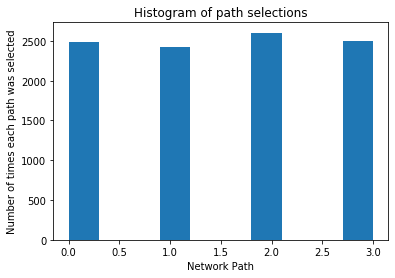

In [4]:
# Visualising the results
plt.hist(path_selected)
plt.title('Histogram of path selections')
plt.xlabel('Network Path')
plt.ylabel('Number of times each path was selected')
plt.show()

In [5]:
# Implementing Upper Confidence Bound (UCB)
import math
N = 10000
d = 4
path_selected = []
numbers_of_selections = [0] * d
sums_of_rewards = [0] * d
total_reward = 0
for n in range(0, N):
    pt = 0
    max_upper_bound = 0
    for i in range(0, d):
        if (numbers_of_selections[i] > 0):
            average_reward = sums_of_rewards[i] / numbers_of_selections[i]
            delta_i = math.sqrt(3/2 * math.log(n + 1) / numbers_of_selections[i])
            upper_bound = average_reward + delta_i
        else:
            upper_bound = 1e400
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            pt = i
    path_selected.append(pt)
    numbers_of_selections[pt] = numbers_of_selections[pt] + 1
    reward = dataset.values[n, pt]
    sums_of_rewards[pt] = sums_of_rewards[pt] + reward
    total_reward = total_reward + reward

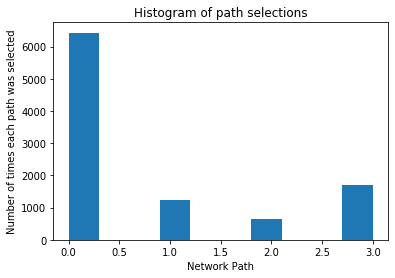

In [6]:
# Visualising the results
plt.hist(path_selected)
plt.title('Histogram of path selections')
plt.xlabel('Network Path')
plt.ylabel('Number of times each path was selected')
plt.show()